In [1]:
import pandas as pd
import numpy as np

filenames = ["Turb_SouthCarolina_S2_st1.csv", 
             "Turb_SouthCarolina_S2_st2.csv", 
             "Turb_SouthCarolina_S2_st3.csv", 
             "Turb_SouthCarolina_S2_st4.csv", 
             "Turb_SouthCarolina_S2_st5.csv", 
             "Turb_SouthCarolina_S2_st6.csv", 
             "Turb_SouthCarolina_S2_st7.csv", 
             "Turb_SouthCarolina_S2_st8.csv", 
             "Turb_SouthCarolina_S2_st9.csv",
             "Turb_Louisiana_S2_st1.csv", 
             "Turb_Louisiana_S2_st2.csv", 
             "Turb_Louisiana_S2_st3.csv", 
             "Turb_Louisiana_S2_st4.csv", 
             "Turb_Louisiana_S2_st5.csv", 
             "Turb_Louisiana_S2_st6.csv",
             "Turb_Mat_S2_st1.csv", 
             "Turb_Mat_S2_st2.csv",
             "Turb_Houston_S2_st1.csv", 
             "Turb_Houston_S2_st2.csv", 
             "Turb_Houston_S2_st3.csv",
             "Turb_Phil_S2_st1.csv", 
             "Turb_Phil_S2_st2.csv"]

parameter = 'nearest_turbidity'

bands_columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'] # For S2

x = []
y = []
site_number = []
dates = []
satellite = []
doy = []

for filename in filenames:

    data = pd.read_csv(filename)
    x.append(data[bands_columns].to_numpy())
    y.append(data[parameter].to_numpy())
    site_number.append(data["site_no"].to_list())
    dates.append(data["ImageAquisition_time"].to_list())
    satellite.append(data["spacecraft_name"].to_list())
    doy.append(data["doy"].to_numpy())

x = np.vstack(x)
y = np.concatenate(y)
doy = np.concatenate(doy)

site_number = [item for sublist in site_number for item in sublist]
dates = [item for sublist in dates for item in sublist]
satellite = [item for sublist in satellite for item in sublist]

print('data_total,' , y.shape)

data_total, (3931,)


In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

def log_scale_transform(X, Y, doy, site_number, dates, satellites):
    
    shift_value_X = np.abs(np.min(X)) + 1  # Shift X to ensure positive values
    shift_value_Y = np.abs(np.min(Y)) + 1  # Shift Y similarly
    
    X_shifted = X + shift_value_X
    Y_shifted = Y + shift_value_Y
    
    X_log = np.log(X_shifted)
    Y_log = np.log(Y_shifted)

    s1 = np.arange(X_log.shape[0])
    np.random.shuffle(s1)
    X_log = X_log[s1, :]
    Y_log = Y_log[s1]
    
    doy_new = doy[s1]
    site_number_new = [site_number[i] for i in s1]
    dates_new = [dates[i] for i in s1]
    satellites_new = [satellites[i] for i in s1]
    
    transformerX = RobustScaler().fit(X_log)
    X_trans = transformerX.transform(X_log)
    min_max_scalerX = MinMaxScaler().fit(X_trans)
    X_trans2 = min_max_scalerX.transform(X_trans)

    transformerY = RobustScaler().fit(np.reshape(Y_log,(-1,1)))
    Y_trans = transformerY.transform(np.reshape(Y_log,(-1,1)))
    min_max_scalerY = MinMaxScaler().fit(Y_trans)
    Y_trans2 = min_max_scalerY.transform(Y_trans)

    return X_trans2, Y_trans2, transformerX, transformerY, min_max_scalerX, min_max_scalerY, shift_value_X, shift_value_Y, doy_new, site_number_new, dates_new, satellites_new, s1

def r_squared(y, y_hat):
 ''' Logarithmic R^2 '''
 slope_, intercept_, r_value, p_value, std_err = stats.linregress(y, y_hat)
 return r_value**2 * 100

def mape(y, y_hat):
 ''' Mean Absolute Percentage Error '''
 return 100 * np.mean(np.abs((y - y_hat) / y))

from sklearn.ensemble import RandomForestRegressor
from scipy import stats

def ytest_to_initial_scale(ytest, min_max_scalerY_turb, transformerY_turb, shift_value_Y):
    ytest_inv1 = min_max_scalerY_turb.inverse_transform(np.reshape(ytest, (-1, 1)))
    ytest_inv2 = transformerY_turb.inverse_transform(ytest_inv1)
    ytest_inv2 = np.exp(ytest_inv2)
    ytest_rescaled = ytest_inv2 - shift_value_Y - 1
    return ytest_rescaled

In [3]:
### For Turb values S2

index = y<=150
y = y[index]
x = x[index, :]

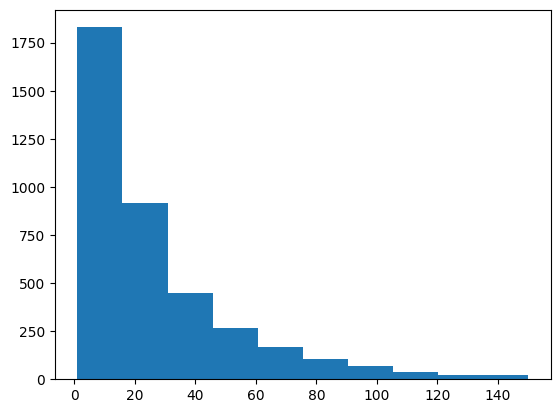

In [4]:
import matplotlib.pyplot as plt
plt.hist(y);

In [5]:
x_rescaled, y_rescaled, transformerX, transformerY, min_max_scalerX, min_max_scalerY, shift_value_X, shift_value_Y, doy_new, site_number_new, dates_new, satellite_new, s1 = log_scale_transform(x, y, doy, site_number, dates, satellite)

y_rescaled = np.squeeze(y_rescaled)

print('data_total,' , y_rescaled.shape)
print('min,' ,np.min(y_rescaled))
print('max,' ,np.max(y_rescaled))
print('mean,' ,np.mean(y_rescaled))
print('std,' ,np.std(y_rescaled))

data_total, (3881,)
min, 0.0
max, 1.0
mean, 0.4910549637838181
std, 0.19951627602273464


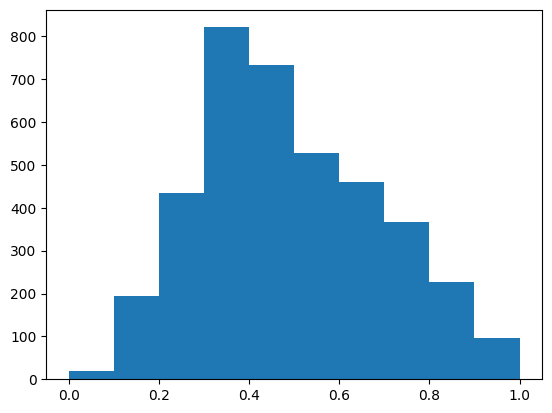

In [6]:
import matplotlib.pyplot as plt
plt.hist(y_rescaled);

In [ ]:
from MDN.model import MDN
import itertools
from tqdm import tqdm
import csv
import os
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold, GridSearchCV, LeaveOneOut, cross_val_predict
from sklearn.model_selection import train_test_split

def write_csv(results_dict, csv_file):
    headers = list(results_dict.keys())
    rows = zip(*results_dict.values())

    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        # Write the header row (dictionary keys)
        writer.writerow(headers)
        # Write each row of values
        for row in rows:
            writer.writerow(row)
            
# --------------------------
# 0) Putting n% of the data aside only for testing!
# --------------------------

test_size = 0.3

print("###################### Step 1")
print("")
print(f"Train and Test split: {test_size * 100}% of dataset is used only for testing...")
print("")
# X_train, X_test, y_train, y_test = train_test_split(
#     x_rescaled, 
#     y_rescaled, 
#     test_size=test_size, 
#     random_state=42
# )

X_train = np.load('/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/paper_MDNKAN/traintest_30_noDOY_5regionsAllinOne/X_train.npy')
X_test = np.load('/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/paper_MDNKAN/traintest_30_noDOY_5regionsAllinOne/X_test.npy')
y_train = np.load('/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/paper_MDNKAN/traintest_30_noDOY_5regionsAllinOne/y_train.npy')
y_test = np.load('/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/paper_MDNKAN/traintest_30_noDOY_5regionsAllinOne/y_test.npy')

# --------------------------
# 1) Tune hyperparameters using, say, 5-fold CV on training data
# --------------------------

print("###################### Step 2")
print("")
print(f"Hyperparameter tuning using k-fold validation on training data (100% - test_size = {100-test_size*100}%)...")
print("")
print("######################")

n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

param_grid = {
    'n_mix': [2, 3, 4, 5, 6, 7, 8],
    'hidden': [[100, 100], [100, 100, 100], [100, 100, 100, 100], [100, 100, 100, 100, 100]],
    'lr': [1e-4, 5e-3, 1e-3],
}

# param_grid = {
#     'n_mix': [4, 5],
#     'hidden': [[100, 100, 100, 100]],
#     'lr': [1e-3],
# }

param_combinations = list(itertools.product(*param_grid.values()))

print("")
print(f"Number of all possible grid search scenarios: {len(list(ParameterGrid(param_grid)))}")

counter = 1

kfold_training_results = []
kfold_test_results = []

results_dict = {
    "n_mix": [],
    "hidden": [],
    "lr": [],
    "Training MAPE": [],
    "Training R2": [],
    "Test MAPE": [],
    "Test R2": []
}

for params in param_combinations:
    print(f"\n####### Grid {counter}")
    counter += 1

    n_mix, hidden, lr = params

    kfold_training_results_per_fold = []
    kfold_test_results_per_fold = []

    for fold, (train_index, val_index) in enumerate(kf.split(X_train), 1):
        print(f"# Fold {fold}")
        x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model_base = MDN(n_mix = n_mix, hidden = hidden, lr = lr, no_load = True, no_save = True, seed = 42)
        model_base = model_base.fit(x_train_fold, y_train_fold)

        y_pred_val_fold_rescaled = model_base.predict(x_val_fold)
        y_pred_test_rescaled = model_base.predict(X_test)

        y_pred_val_fold_original = np.squeeze(ytest_to_initial_scale(
        y_pred_val_fold_rescaled, min_max_scalerY, transformerY, shift_value_Y
        ))
        y_pred_test_original = np.squeeze(ytest_to_initial_scale(
            y_pred_test_rescaled, min_max_scalerY, transformerY, shift_value_Y
        ))
        y_test_original = np.squeeze(ytest_to_initial_scale(
            y_test, min_max_scalerY, transformerY, shift_value_Y
        ))
        y_val_fold_original = np.squeeze(ytest_to_initial_scale(
            y_val_fold, min_max_scalerY, transformerY, shift_value_Y
        ))

        MAPE_value = mape(y_val_fold_original, y_pred_val_fold_original)
        r2_value = r_squared(y_val_fold_original, y_pred_val_fold_original)

        kfold_training_results_per_fold.append([MAPE_value, r2_value])

        MAPE_value = mape(y_test_original, y_pred_test_original)
        r2_value = r_squared(y_test_original, y_pred_test_original)

        kfold_test_results_per_fold.append([MAPE_value, r2_value])

    mean_train = np.array(kfold_training_results_per_fold).mean(axis=0).tolist()
    mean_test = np.array(kfold_test_results_per_fold).mean(axis=0).tolist()

    kfold_training_results.append(mean_train)
    kfold_test_results.append(mean_test)

    # Store results for this scenario
    results_dict["n_mix"].append(n_mix)
    results_dict["hidden"].append(hidden)  # as a list
    results_dict["lr"].append(lr)
    results_dict["Training MAPE"].append(mean_train[0])
    results_dict["Training R2"].append(mean_train[1])
    results_dict["Test MAPE"].append(mean_test[0])
    results_dict["Test R2"].append(mean_test[1])

    # os.makedirs("MDNhyperparametertuning", exist_ok=True)
    write_csv(results_dict, '/home/user/PHDLund/PythonProjects_github/WQ_SAT_ML/paper_MDNKAN/traintest_30_noDOY_5regionsAllinOne/MDNhyperparametertuning.csv')

In [ ]:
### Finding best model

import pandas as pd
import numpy as np
import ast
import shutil

# 1) Read the CSV
df = pd.read_csv("MDNhyperparametertuning/MDNhyperparametertuning.csv")

# 2) Remove rows with infinities or NaNs (if necessary)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Training MAPE", "Test MAPE", 
                                                         "Training R2", "Test R2"])

# 3a) Sort by Test MAPE (ascending = best = lowest MAPE)
df_sorted_by_mape = df.sort_values(by="Test MAPE", ascending=True)

# print("Top 5 rows by Test MAPE:")
# print(df_sorted_by_mape.head(5))

# best_row = df_sorted_by_mape.iloc[0]

n_mix = df_sorted_by_mape.iloc[0]['n_mix']
hidden = ast.literal_eval(df_sorted_by_mape.iloc[0]['hidden'])
lr = df_sorted_by_mape.iloc[0]['lr']


from MDN.model import MDN
import itertools
from tqdm import tqdm
import csv
import os
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold, GridSearchCV, LeaveOneOut, cross_val_predict
from sklearn.model_selection import train_test_split

# --------------------------
# 0) Putting n% of the data aside only for testing!
# --------------------------

test_size = 0.3

print("###################### Step 1")
print("")
print(f"Train and Test split: {test_size * 100}% of dataset is used only for testing...")
print("")

X_train, X_test, y_train, y_test = train_test_split(
    x_rescaled, 
    y_rescaled, 
    test_size=test_size, 
    random_state=42
)

# --------------------------
# 1) Evaluating model on test data by running it for 200 times and save the best model
# --------------------------

number_of_runs = 300

print("###################### Step 2")
print("")
print("Evaluating model on test data by running it for 200 times and save the best model")
print("")
print("######################")

bestMAPE_MAPE = 100
bestR2_R2 = 0

for i in range(number_of_runs):

    print(f'Run # {i}')

    model_base = MDN(n_mix = n_mix, hidden = hidden, lr = lr, no_load = True, no_save = False, model_path = 'MDNhyperparametertuning/' + str(i))
    model_base = model_base.fit(X_train, y_train)

    y_pred_test_rescaled = model_base.predict(X_test)

    _, coefs_training = model_base.predict(X_train, return_coefs=True)
    _, coefs_test = model_base.predict(X_test, return_coefs=True)

    prior_training = np.reshape(coefs_training[0],(-1,n_mix))
    mu_training = np.reshape(coefs_training[1],(-1,n_mix))
    sigma_training = np.reshape(coefs_training[2],(-1,n_mix))

    prior_test = np.reshape(coefs_test[0],(-1,n_mix))
    mu_test = np.reshape(coefs_test[1],(-1,n_mix))
    sigma_test = np.reshape(coefs_test[2],(-1,n_mix))

    y_pred_test_original = np.squeeze(ytest_to_initial_scale(y_pred_test_rescaled, min_max_scalerY, transformerY, shift_value_Y))
    y_test_original = np.squeeze(ytest_to_initial_scale(y_test, min_max_scalerY, transformerY, shift_value_Y))

    MAPE_value = mape(y_test_original, y_pred_test_original)
    r2_value = r_squared(y_test_original, y_pred_test_original)

    # print(f'#### Run {i}')
    # print('')
    # print('MAPE = ', MAPE_value)
    # print('R2 = ', r2_value)
    # print('')

    if bestMAPE_MAPE > MAPE_value:
        
        bestMAPE_MAPE = MAPE_value
        bestR2_MAPE = r2_value
        bestModel_MAPE = i

        np.save(f'MDNhyperparametertuning/{i}/prior_training.npy', prior_training)
        np.save(f'MDNhyperparametertuning/{i}/mu_training.npy', mu_training)
        np.save(f'MDNhyperparametertuning/{i}/sigma_training.npy', sigma_training)
        np.save(f'MDNhyperparametertuning/{i}/prior_test.npy', prior_test)
        np.save(f'MDNhyperparametertuning/{i}/mu_test.npy', mu_test)
        np.save(f'MDNhyperparametertuning/{i}/sigma_test.npy', sigma_test)


    if bestR2_R2 < r2_value:
        
        bestMAPE_R2 = MAPE_value
        bestR2_R2 = r2_value
        bestModel_R2 = i

        np.save(f'MDNhyperparametertuning/{i}/prior_training.npy', prior_training)
        np.save(f'MDNhyperparametertuning/{i}/mu_training.npy', mu_training)
        np.save(f'MDNhyperparametertuning/{i}/sigma_training.npy', sigma_training)
        np.save(f'MDNhyperparametertuning/{i}/prior_test.npy', prior_test)
        np.save(f'MDNhyperparametertuning/{i}/mu_test.npy', mu_test)
        np.save(f'MDNhyperparametertuning/{i}/sigma_test.npy', sigma_test)

print('')
print('best Model MAPE id = ', bestModel_MAPE)
print('Best MAPE = ', bestMAPE_MAPE)
print('R2 = ', bestR2_MAPE)
print('')

print('')
print('best Model R2 id = ', bestModel_R2)
print('Best MAPE = ', bestMAPE_R2)
print('R2 = ', bestR2_R2)
print('')

folders_to_keep = {str(bestModel_MAPE), str(bestModel_R2)}

parent_dir = 'MDNhyperparametertuning'

for item in os.listdir(parent_dir):
    item_path = os.path.join(parent_dir, item)
    if os.path.isdir(item_path) and (item not in folders_to_keep):
        shutil.rmtree(item_path)

###################### Step 1

Train and Test split: 30.0% of dataset is used only for testing...

###################### Step 2

Calling saved model

######################

MAPE =  31.730659881072796
R2 =  64.61465891651672



Text(0, 0.5, 'ML estimates')

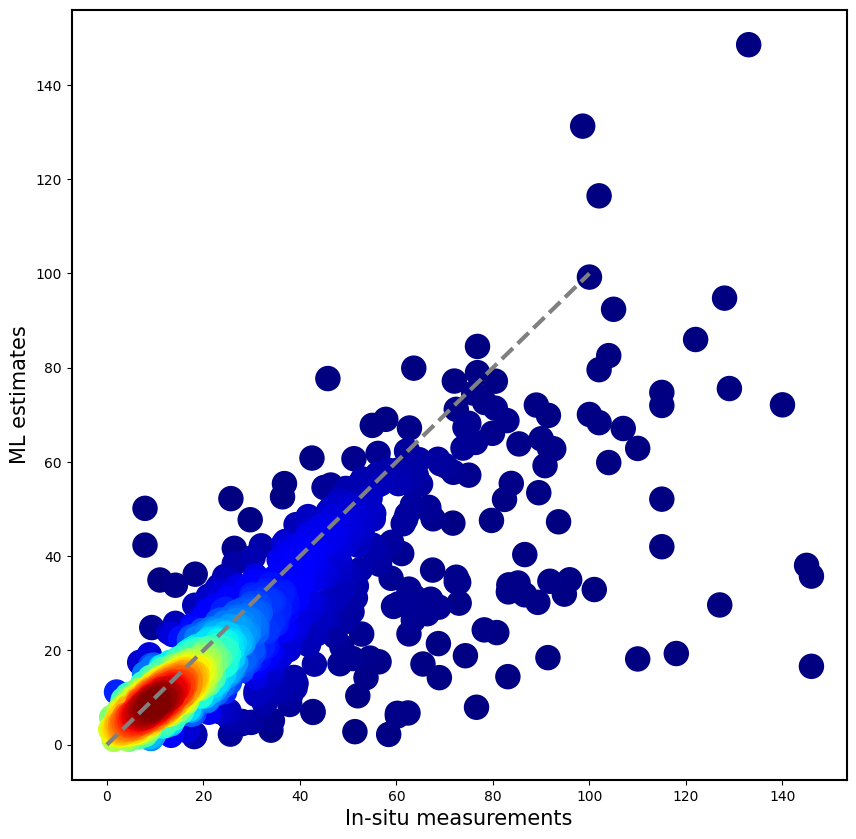

In [12]:
### Output of the best model

import pandas as pd
import numpy as np
import ast
import shutil

# 1) Read the CSV
df = pd.read_csv("MDNhyperparametertuning/MDNhyperparametertuning.csv")

# 2) Remove rows with infinities or NaNs (if necessary)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Training MAPE", "Test MAPE", 
                                                         "Training R2", "Test R2"])

# 3a) Sort by Test MAPE (ascending = best = lowest MAPE)
df_sorted_by_mape = df.sort_values(by="Test MAPE", ascending=True)

# print("Top 5 rows by Test MAPE:")
# print(df_sorted_by_mape.head(5))

# best_row = df_sorted_by_mape.iloc[0]

n_mix = df_sorted_by_mape.iloc[0]['n_mix']
hidden = ast.literal_eval(df_sorted_by_mape.iloc[0]['hidden'])
lr = df_sorted_by_mape.iloc[0]['lr']


from MDN.model import MDN
import itertools
from tqdm import tqdm
import csv
import os
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold, GridSearchCV, LeaveOneOut, cross_val_predict
from sklearn.model_selection import train_test_split

# --------------------------
# 0) Putting n% of the data aside only for testing!
# --------------------------

test_size = 0.3

print("###################### Step 1")
print("")
print(f"Train and Test split: {test_size * 100}% of dataset is used only for testing...")
print("")

X_train, X_test, y_train, y_test = train_test_split(
    x_rescaled, 
    y_rescaled, 
    test_size=test_size, 
    random_state=42
)

print("###################### Step 2")
print("")
print("Calling saved model")
print("")
print("######################")

model_base = MDN(n_mix = n_mix, hidden = hidden, lr = lr, no_load = False, no_save = True, model_path = 'MDNhyperparametertuning/247')
model_base = model_base.fit(X_train, y_train)
y_pred_test_rescaled = model_base.predict(X_test)


y_pred_test_original = np.squeeze(ytest_to_initial_scale(y_pred_test_rescaled, min_max_scalerY, transformerY, shift_value_Y))
y_test_original = np.squeeze(ytest_to_initial_scale(y_test, min_max_scalerY, transformerY, shift_value_Y))

MAPE_value = mape(y_test_original, y_pred_test_original)
r2_value = r_squared(y_test_original, y_pred_test_original)

print('')
print('MAPE = ', MAPE_value)
print('R2 = ', r2_value)
print('')


import matplotlib
from scipy.stats import gaussian_kde

matplotlib.rcParams['axes.linewidth'] = 1.5

x = y_test_original
y = y_pred_test_original

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(figsize = (10,10))
ax.plot([0,100], [0,100], color='grey', linestyle='dashed', linewidth=3)

ax.scatter(x, y, c=z, s=300, cmap='jet')

# ax.set_xlim([5, 10])
# ax.set_ylim([5, 10])

ax.set_xlabel('In-situ measurements', fontsize = 15)
ax.set_ylabel('ML estimates', fontsize = 15)

In [ ]:
prior_training = np.reshape(coefs_training[0],(-1,n_mix))
mu_training = np.reshape(coefs_training[1],(-1,n_mix))
sigma_training = np.reshape(coefs_training[2],(-1,n_mix))

prior_training.shape

In [ ]:
import ast

df_sorted_by_mape.iloc[0]['lr']

In [ ]:
kfold_training_results

In [ ]:
kfold_test_results_per_fold

In [ ]:
kfold_test_results

In [ ]:
print("###################### Step 3")
print("Model validation using the best parameters found and k-fold method on training data...")

best_rf = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'],  
                                max_depth = grid_search.best_params_['max_depth'], 
                                min_samples_leaf = grid_search.best_params_['min_samples_leaf'], 
                                min_samples_split = grid_search.best_params_['min_samples_split'], 
                                random_state=42)


kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

mape_list_training = []
r2_list_training   = []

mape_list_test = []
r2_list_test  = []

counter = 1

for train_idx, test_idx in kf.split(X_train):

    print(f'######## Fold{counter}')
    counter += 1
    
    x_train_kfold, x_test_kfold = X_train[train_idx], X_train[test_idx]
    y_train_kfold, y_test_kfold = y_train[train_idx], y_train[test_idx]
    
    # Fit the best RF on the training fold
    best_rf.fit(x_train_kfold, y_train_kfold)
    
    # Predict on the test fold
    y_pred_rescaled_kfold = best_rf.predict(x_test_kfold)
    
    # Transform y_test and predictions back to original scale
    y_pred_original_kfold = np.squeeze(ytest_to_initial_scale(
        y_pred_rescaled_kfold, 
        min_max_scalerY, 
        transformerY, 
        shift_value_Y
    ))
    y_test_original_kfold = np.squeeze(ytest_to_initial_scale(
        y_test_kfold, 
        min_max_scalerY, 
        transformerY, 
        shift_value_Y
    ))

    # Compute metrics on THIS fold
    mape_list_training.append(mape(y_test_original_kfold, y_pred_original_kfold))
    r2_list_training.append(r_squared(y_test_original_kfold, y_pred_original_kfold))

    # Predict on the test fold
    y_pred_rescaled = best_rf.predict(X_test)
    
    # Transform y_test and predictions back to original scale
    y_pred_original = np.squeeze(ytest_to_initial_scale(
        y_pred_rescaled, 
        min_max_scalerY, 
        transformerY, 
        shift_value_Y
    ))
    y_test_original = np.squeeze(ytest_to_initial_scale(
        y_test, 
        min_max_scalerY, 
        transformerY, 
        shift_value_Y
    ))
    # Compute metrics on THIS fold
    mape_list_test.append(mape(y_test_original, y_pred_original))
    r2_list_test.append(r_squared(y_test_original, y_pred_original))

# Report average metrics across folds
print("Training : Mean MAPE (K-fold):", np.mean(mape_list_training))
print("Training : Std  MAPE (K-fold):", np.std(mape_list_training))
print("Training : Mean R²   (K-fold):", np.mean(r2_list_training))
print("Training : Std  R²   (K-fold):", np.std(r2_list_training))

# Report average metrics across folds
print("Test : Mean MAPE (K-fold):", np.mean(mape_list_test))
print("Test : Std  MAPE (K-fold):", np.std(mape_list_test))
print("Test : Mean R²   (K-fold):", np.mean(r2_list_test))
print("Test : Std  R²   (K-fold):", np.std(r2_list_test))

print("###################### Step 3")
print("Model validation using the best parameters found and whole training data on test data only")

best_rf = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'],  
                                max_depth = grid_search.best_params_['max_depth'], 
                                min_samples_leaf = grid_search.best_params_['min_samples_leaf'], 
                                min_samples_split = grid_search.best_params_['min_samples_split'], 
                                random_state=42)

best_rf.fit(X_train, y_train)

y_pred_rescaled = best_rf.predict(X_test)

y_pred_original = np.squeeze(ytest_to_initial_scale(
    y_pred_rescaled, min_max_scalerY, transformerY, shift_value_Y
))
y_test_original = np.squeeze(ytest_to_initial_scale(
    y_test, min_max_scalerY, transformerY, shift_value_Y
))

MAPE_value = mape(y_test_original, y_pred_original)
r2_value = r_squared(y_test_original, y_pred_original)

print("MAPE:", MAPE_value)
print("R2  :", r2_value)

# print("###################### Step 4")
# print("LeaveOneOut on the whole data using the best parameters found...")

# best_rf = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'],  
#                                 max_depth = grid_search.best_params_['max_depth'], 
#                                 min_samples_leaf = grid_search.best_params_['min_samples_leaf'], 
#                                 min_samples_split = grid_search.best_params_['min_samples_split'], 
#                                 random_state=42)

# y_preds_rescaled = cross_val_predict(best_rf, x_rescaled, y_rescaled, cv = LeaveOneOut())

# y_preds = ytest_to_initial_scale(y_preds_rescaled, min_max_scalerY, transformerY, shift_value_Y)
# y_preds = np.squeeze(y_preds)

# y_test = ytest_to_initial_scale(y_rescaled, min_max_scalerY, transformerY, shift_value_Y)
# y_test = np.squeeze(y_test)

# print("MAPE :", mape(y_test, y_preds))
# print("R2   :", r_squared(y_test, y_preds))